### Develop Statistical Arbitrage Strategy using Highly Correlated, Cointegrated Trading Pairs

1. Statistical Arbitrage, Mean Reversion Signal on Price Ratio
2. Incorporate Momentum Overlay

In [1]:
from binance_market_module import BinanceMarketModule
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import scipy.stats as st
pd.options.mode.chained_assignment = None  # default='warn'
from statarb_core import StatArb

In [2]:
fg = (20, 4)
interval = '1d'
start = '2017-01-01'
end = '2023-03-01'

In [3]:
bmod = BinanceMarketModule('spot')
# check all available datasets for backtesting, and obtain relevant tickers

tickers = ['BTCUSDT', 'ETHUSDT', 'ETCUSDT', 'LTCUSDT', 'AAVEUSDT', 'ADAUSDT', 'BNBUSDT', 'XRPUSDT', 'NEOUSDT']
# tickers = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'AAVEUSDT']
df = pd.DataFrame()
for ticker in tickers:
    # pull data and construct
    try:
        current_df = bmod.retrieveOHLCV(ticker, interval, start, end)
        current_df = current_df.set_index('close_ts')[['close']].rename(columns={'close': ticker})
        df = pd.concat([df, current_df], axis=1)
        print('Ticker Done:', ticker)
    except:
        continue
    
# truncate dataset till all rows have data
# df.dropna(how='any', axis=0, inplace=True)

Ticker Done: BTCUSDT
Ticker Done: ETHUSDT
Ticker Done: LTCUSDT
Ticker Done: AAVEUSDT
Ticker Done: ADAUSDT
Ticker Done: BNBUSDT
Ticker Done: XRPUSDT
Ticker Done: NEOUSDT


Create Training and Test Sets, and identify optimal parameters for strategy

## Sole Mean Reversion Strategy for Cointegrated Pairs

Confidence Level: 0.8
Rolling Window: 100
Transaction Cost %: 0.1


,Portfolio,Asset X,Asset Y
Sharpe,0.909611,1.015419,0.683016
Sortino,1.086872,1.371406,1.063830
Max Drawdown,0.519023,0.641415,0.657820
CAGR,0.509447,0.665992,0.079360
Cumulative Return,0.405896,0.525498,0.065226


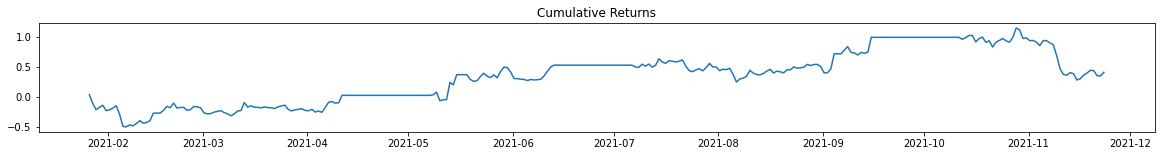

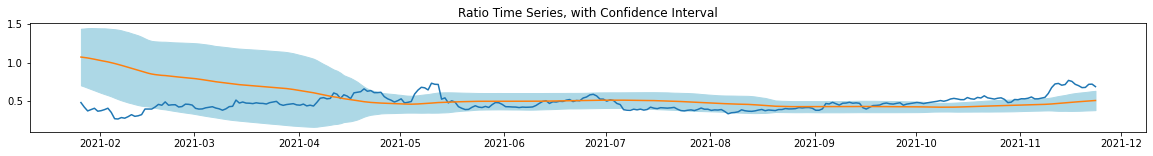

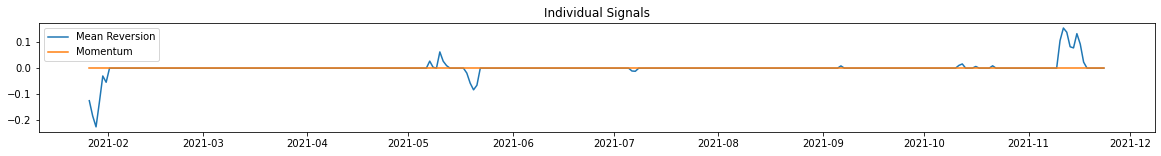

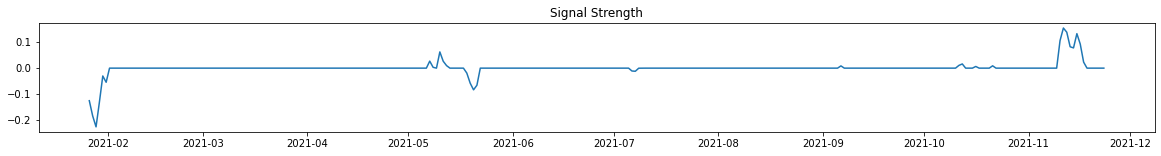

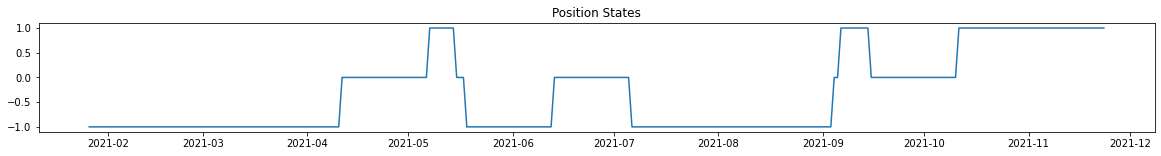

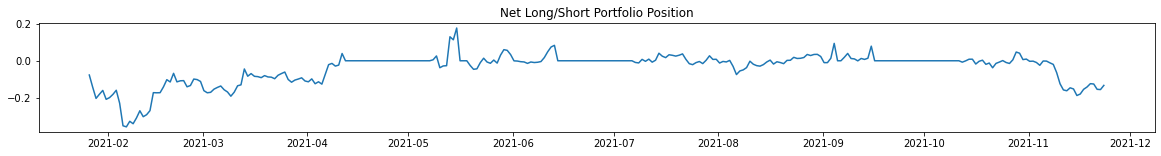

In [8]:
confidence = 0.8  # confidence interval, meaning threshold is anything outside of 
window = int(100)  # 100 works, in days
transaction_cost = 0.001  # assuming 0.1% transaction cost
w = 5  # rolling interval to calculate hedge ratio
# selected_tickers = ['BTCUSDT', 'ETHUSDT']
selected_tickers = ['LTCUSDT', 'AAVEUSDT']
df_subset = df[selected_tickers].dropna(how='any', axis=0)

# train on half
midpoint = len(df_subset) // 2
train_df = df_subset[:midpoint]
test_df = df_subset[midpoint-window-w:]

# initialise mod
weights = [1, 0]  # 0, 7

# train
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost * 100}')

dataset = train_df
mod = StatArb(dataset, interval='day')
mod.momentum_halflife = 7
mod.reset()
mod.generate_signal(window, confidence, weights)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
results = mod.results()
display(results)

# plot results
mod.plot_all()
plt.show()

Backtest on Test Dataset

,Portfolio,Asset X,Asset Y
Sharpe,0.528712,-0.650809,-0.575632
Sortino,0.519859,-0.915644,-0.905265
Max Drawdown,0.488742,0.467387,0.346029
CAGR,0.143479,-0.638165,-0.778410
Cumulative Return,0.161257,-0.678109,-0.813687


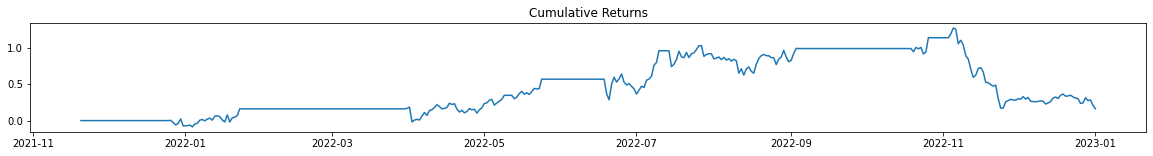

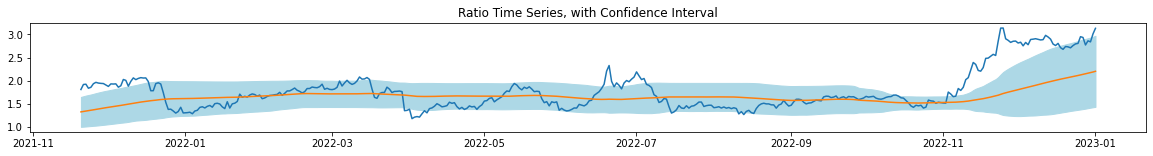

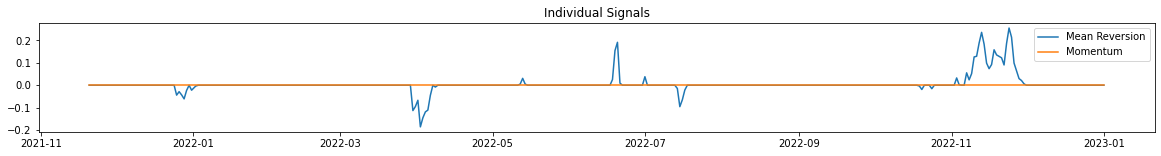

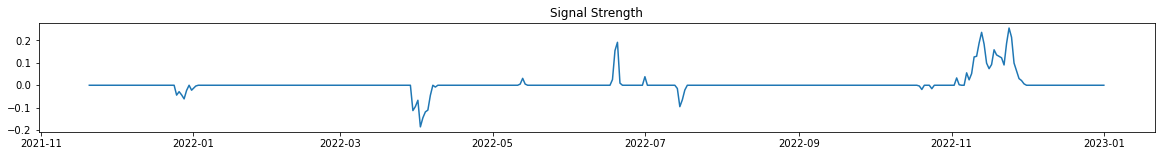

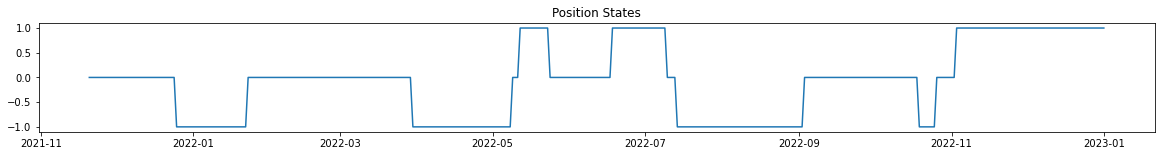

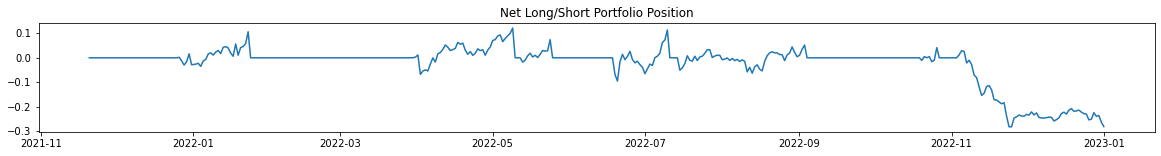

In [9]:
dataset = test_df
mod = StatArb(dataset, interval='day')
mod.momentum_halflife = 7
mod.generate_signal(window, confidence, weights)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
results = mod.results()
display(results)

# plot results
mod.plot_all()
plt.show()

## Pure Momentum Strategies

Confidence Level: 0.8
Rolling Window: 100
Transaction Cost %: 0.1


,Portfolio,Asset X,Asset Y
Sharpe,1.440410,0.363151,0.185879
Sortino,1.923061,0.465146,0.247367
Max Drawdown,0.565432,0.679456,0.771742
CAGR,0.897087,-0.078250,-0.313310
Cumulative Return,3.657696,-0.177806,-0.594698


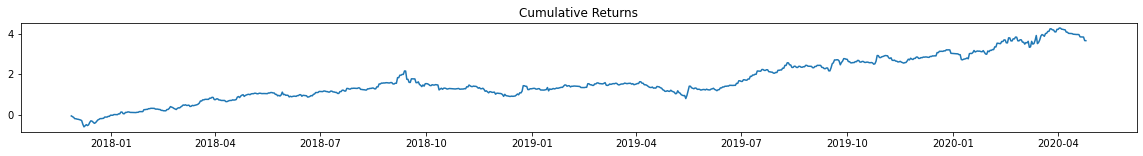

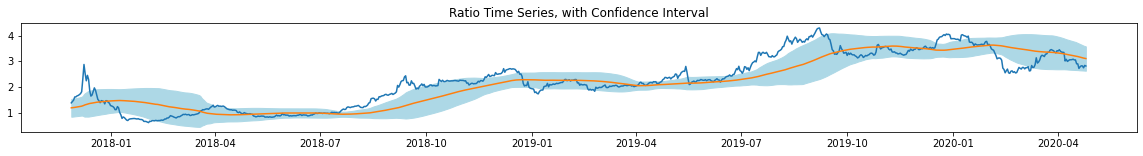

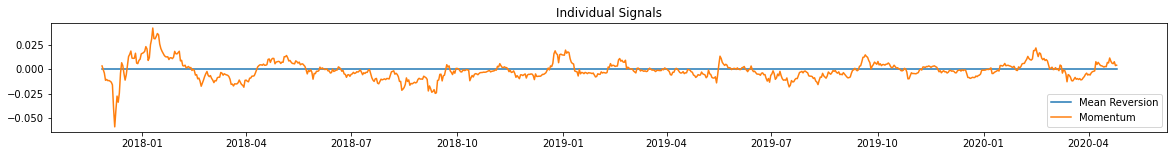

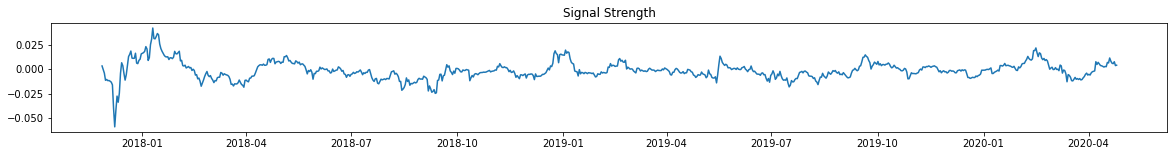

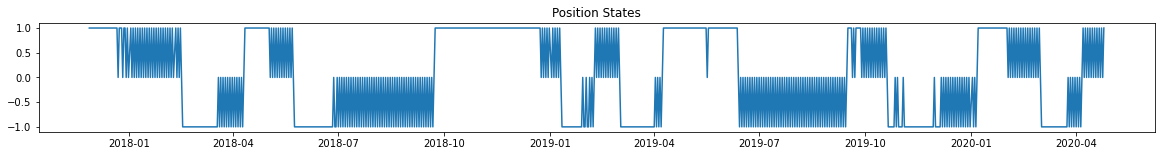

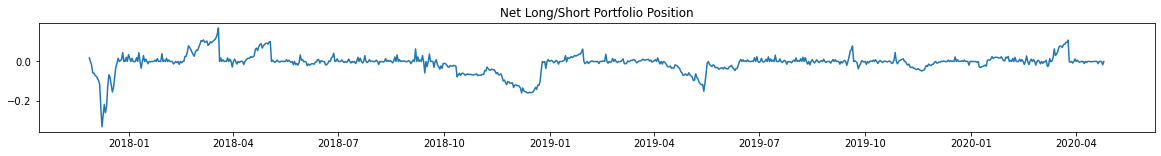

In [10]:
confidence = 0.8  # confidence interval, meaning threshold is anything outside of 
window = int(100)  # 100 works, in days
transaction_cost = 0.001  # assuming 0.1% transaction cost
w = 5  # rolling interval to calculate hedge ratio
selected_tickers = ['BTCUSDT', 'ETHUSDT']
df_subset = df[selected_tickers].dropna(how='any', axis=0)

# train on half
midpoint = len(df_subset) // 2
train_df = df_subset[:midpoint]
test_df = df_subset[midpoint-window-w:]

# initialise mod
weights = [0, 1]  # 0, 7

# train
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost * 100}')

dataset = train_df
mod = StatArb(dataset, interval='day')
mod.momentum_halflife = 7
mod.reset()
mod.generate_signal(window, confidence, weights)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
results = mod.results()
display(results)

# plot results
mod.plot_all()
plt.show()

### Backtest against Test Set - Momentum Strategy

,Portfolio,Asset X,Asset Y
Sharpe,1.018756,0.820643,1.245371
Sortino,1.534736,1.169160,1.808636
Max Drawdown,0.452746,0.684942,0.770217
CAGR,0.457707,0.387975,1.060267
Cumulative Return,1.759233,1.417995,6.005564


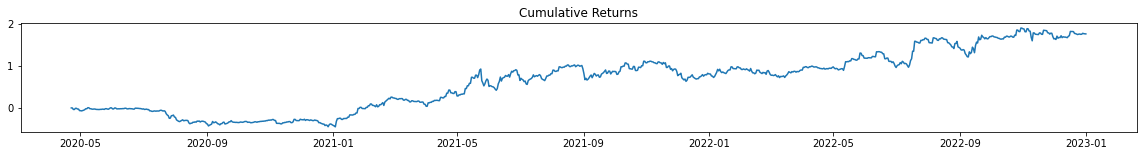

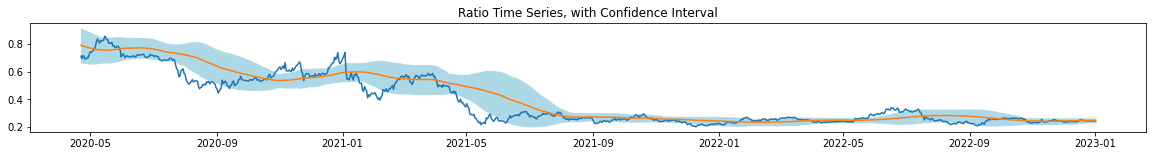

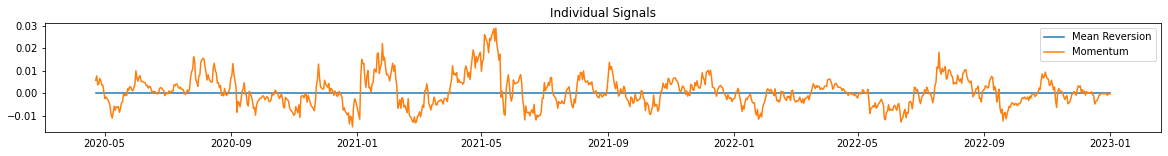

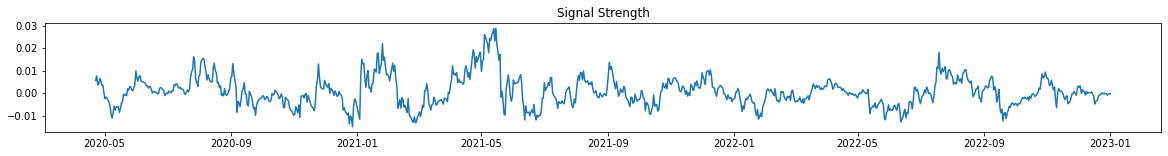

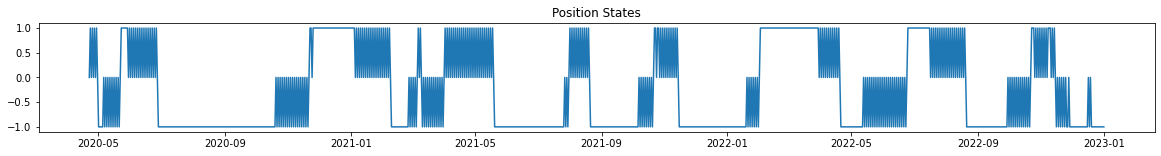

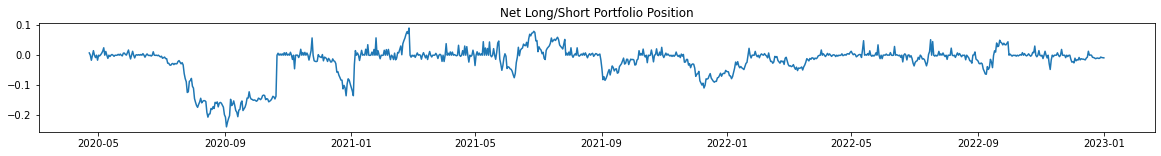

In [11]:
dataset = test_df
mod = StatArb(dataset, interval='day')
mod.momentum_halflife = 7
mod.reset()
mod.generate_signal(window, confidence, weights)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
results = mod.results()
display(results)

# plot results
mod.plot_all()
plt.show()

## How do I weigh the two signals dynamically?

Perform Grid Search to obtain Optimal Parameters

In [ ]:
#

In [5]:
mod.window

180

In [6]:
mod.momentum_halflife

7

In [8]:
d = mod.generate_momentum_signal()

In [10]:
d['new_momentum_signal'] = d['momentum_signal'] - d['ratio_change_std']

<AxesSubplot: xlabel='close_ts'>

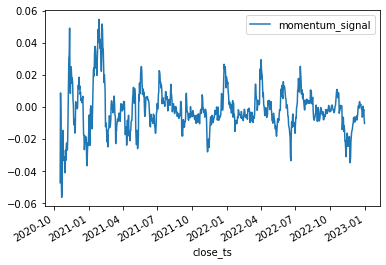

In [12]:
d[['momentum_signal']].plot()

                   Portfolio   Asset X   Asset Y
Sharpe              0.202410  0.797636  1.222133
Sortino             0.212557  1.137279  1.776485
Max Drawdown        0.624045  0.684942  0.765759
CAGR               -0.016037  0.388608  1.061174
Cumulative Return  -0.042649  1.423145  6.027791


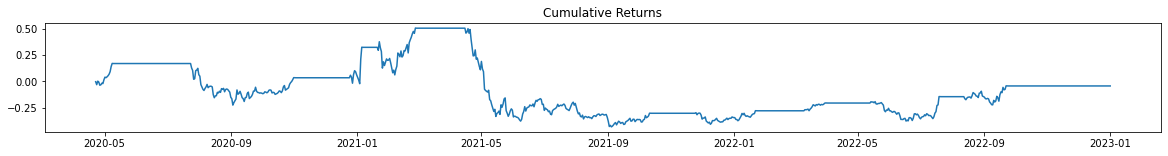

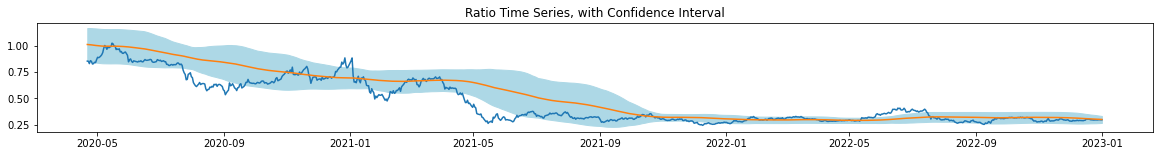

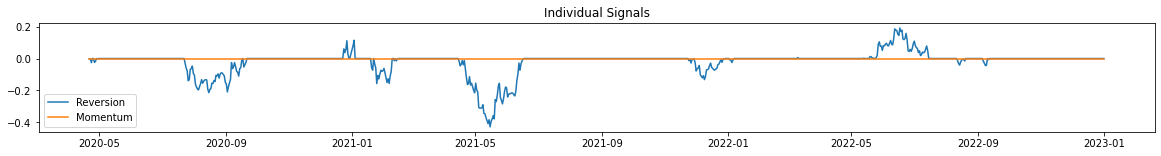

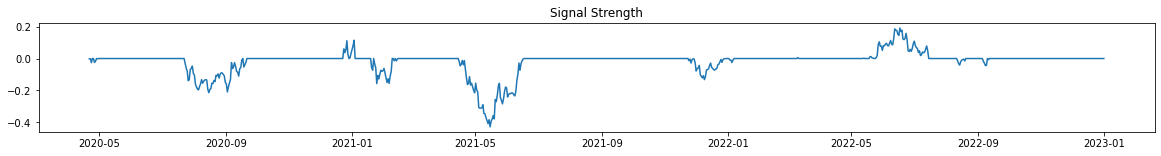

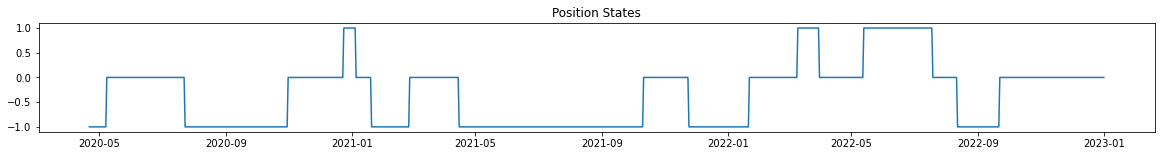

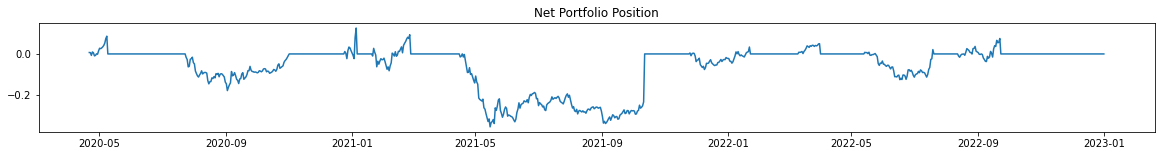

In [8]:
mod = StatArb(test_df, interval='day')
mod.momentum_halflife = 7
mod.generate_signal(window, confidence, weights)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
results = mod.results()
print(results)

# plot results
mod.plot_all()
plt.show()

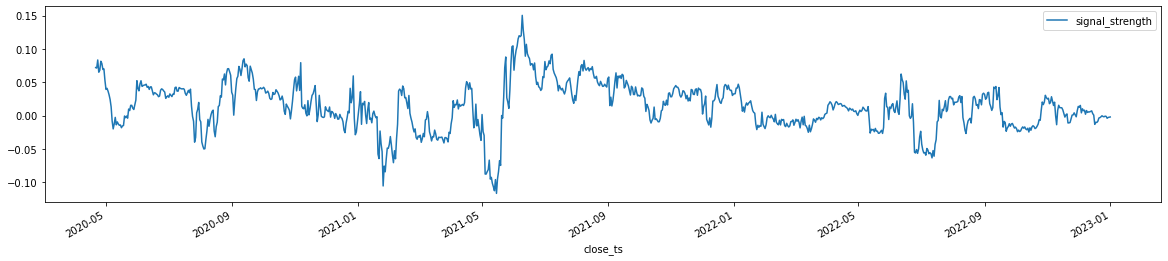

In [16]:
mod.p_data[['signal_strength']].plot(figsize=fg)
plt.show()

Need to implement defensive signal. Do not place a position

In [6]:
# checking on momentum to create new signal --> looking at percentage changes
d = mod.p_data.copy()

In [7]:
d['ratio_pct_change'] = d['ratio'].pct_change()
d['ratio_change_sum'] = d['ratio_pct_change'].ewm(halflife=14).mean()  # considering last 14 days for exponential moving average
d['momentum_signal'] = -1 * d['ratio_change_sum']

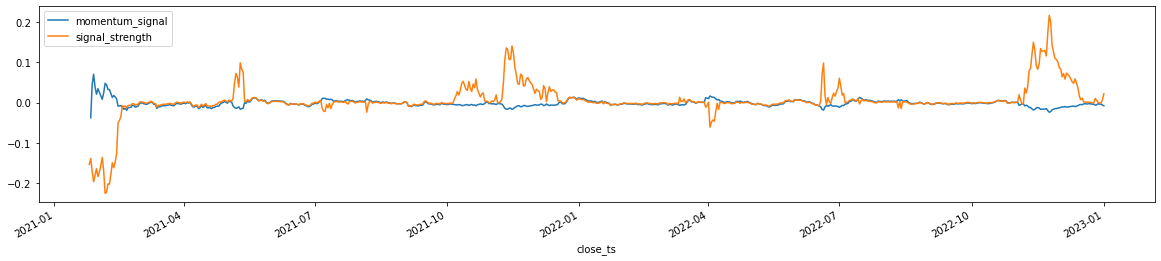

In [8]:
# d[['combined_signal', 'signal_strength', 'ratio_change_sum']].plot(figsize=fg)
# d[['combined_signal', 'signal_strength']].plot(figsize=fg)
d[['momentum_signal', 'signal_strength']].plot(figsize=fg)
plt.show()

In [9]:
# requires weighting of signals
weights = [0.6, 0.4]
d['combined_signal'] = (weights[0] * d['signal_strength']) + (weights[1] * d['momentum_signal'])

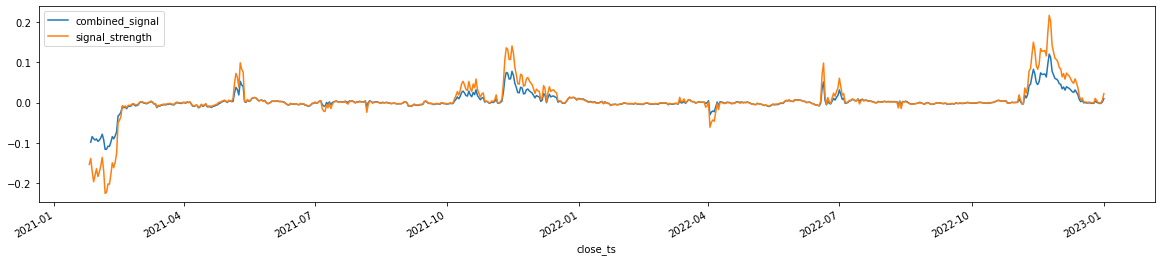

In [10]:
d[['combined_signal', 'signal_strength']].plot(figsize=fg)
plt.show()

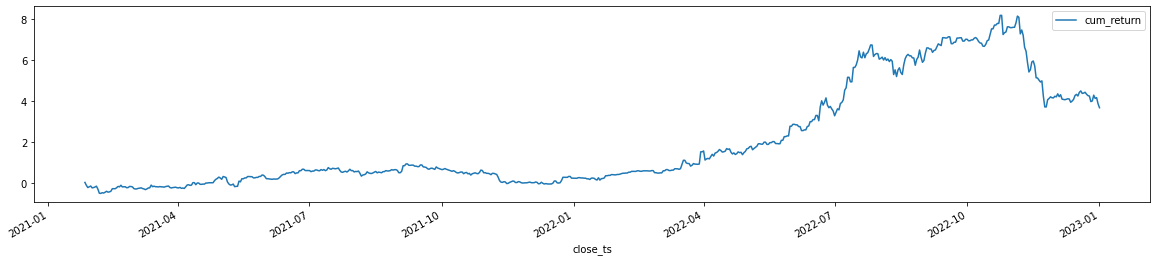

In [11]:
d[['cum_return']].plot(figsize=fg)
plt.show()

In [12]:
d = mod.generate_momentum_signal()

In [13]:
momentum = d['momentum_signal'] # pandas series

In [14]:
mod.data

,x,y,norm_x,pct_change_x,norm_y,pct_change_y,ratio
close_ts,,,,,,,
2020-10-16 07:59:59.999,49.53,42.999,1.000000,NaN,1.000000,NaN,1.000000
2020-10-17 07:59:59.999,47.60,39.461,0.961034,-0.038966,0.917719,-0.082281,1.047198
2020-10-18 07:59:59.999,46.93,41.365,0.947507,-0.014076,0.961999,0.048250,0.984935
2020-10-19 07:59:59.999,47.54,40.750,0.959822,0.012998,0.947696,-0.014868,1.012795
2020-10-20 07:59:59.999,47.99,35.980,0.968908,0.009466,0.836764,-0.117055,1.157923
...,...,...,...,...,...,...,...
2022-12-27 23:59:59.999,68.67,57.500,1.386432,-0.029811,1.337240,0.026786,1.036786
2022-12-28 23:59:59.999,66.32,53.800,1.338986,-0.034222,1.251192,-0.064348,1.070169
2022-12-29 23:59:59.999,66.66,54.500,1.345851,0.005127,1.267471,0.013011,1.061839


In [15]:
dd = mod.generate_reversion_signal()

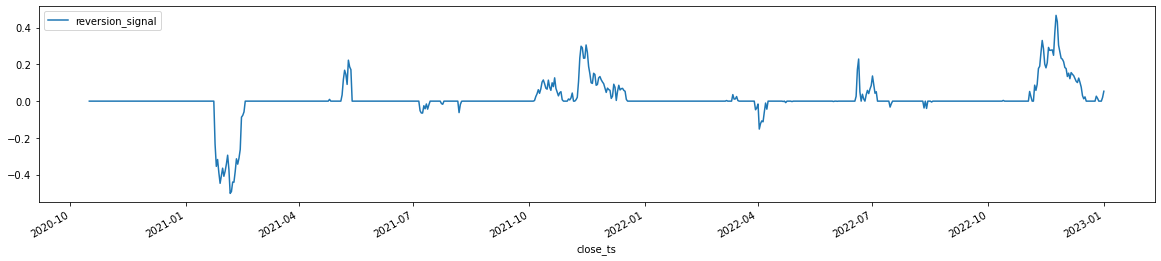

In [16]:
dd[['reversion_signal']].plot(figsize=fg)
plt.show()

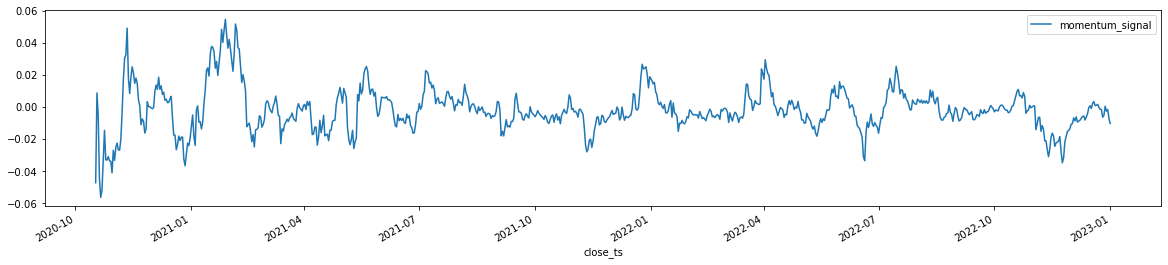

In [17]:
d[['momentum_signal']].plot(figsize=fg)
plt.show()

In [18]:
ww = [1, 10]
abc = ww[0] * dd['reversion_signal'] + ww[1] * d['momentum_signal']

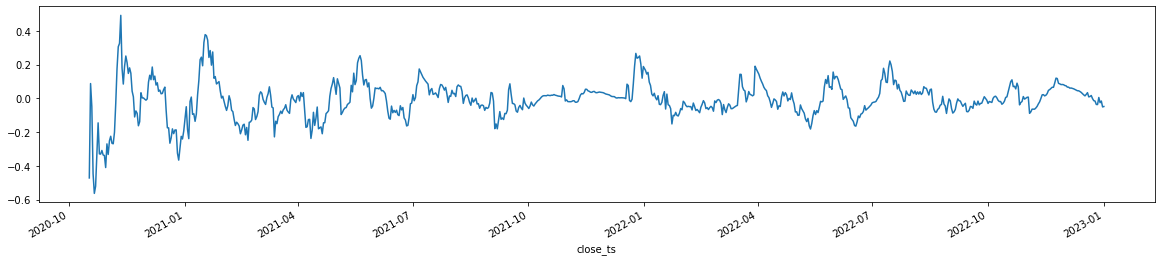

In [19]:
abc.plot(figsize=fg)
plt.show()

Test out new weighted momentum strategy

In [26]:
df

,BTCUSDT,ETHUSDT,LTCUSDT,AAVEUSDT,ADAUSDT,BNBUSDT,XRPUSDT,NEOUSDT
close_ts,,,,,,,,
2017-08-18 07:59:59.999,4285.08,302.00,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-19 07:59:59.999,4108.37,293.96,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-20 07:59:59.999,4139.98,290.91,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-21 07:59:59.999,4086.29,299.10,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-22 07:59:59.999,4016.00,323.29,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-27 23:59:59.999,16706.36,1211.55,68.67,57.5,0.2603,NaN,0.3675,NaN
2022-12-28 23:59:59.999,16547.31,1190.15,66.32,53.8,0.2482,NaN,0.3558,NaN
2022-12-29 23:59:59.999,16633.47,1200.49,66.66,54.5,0.2440,NaN,0.3421,NaN


In [ ]:
# initialise mod
mod = StatArb(train_vdf[[x, y]], interval='day')

confidence = 0.3  # confidence interval, meaning threshold is anything outside of 
window = int(100)
transaction_cost = 0.00

# train
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost}')
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
mod.results()

In [50]:
mod.data


,x,y,norm_x,pct_change_x,norm_y,pct_change_y,ratio
close_ts,,,,,,,
2020-10-16 07:59:59.999,49.53,42.999,1.000000,NaN,1.000000,NaN,1.000000
2020-10-17 07:59:59.999,47.60,39.461,0.961034,-0.038966,0.917719,-0.082281,1.047198
2020-10-18 07:59:59.999,46.93,41.365,0.947507,-0.014076,0.961999,0.048250,0.984935
2020-10-19 07:59:59.999,47.54,40.750,0.959822,0.012998,0.947696,-0.014868,1.012795
2020-10-20 07:59:59.999,47.99,35.980,0.968908,0.009466,0.836764,-0.117055,1.157923
...,...,...,...,...,...,...,...
2022-12-27 23:59:59.999,68.67,57.500,1.386432,-0.029811,1.337240,0.026786,1.036786
2022-12-28 23:59:59.999,66.32,53.800,1.338986,-0.034222,1.251192,-0.064348,1.070169
2022-12-29 23:59:59.999,66.66,54.500,1.345851,0.005127,1.267471,0.013011,1.061839


In [ ]:
# combine new signal with existing signal
# if momentum is going down substantially, don't put in a long position


In [ ]:
# initialise mod
mod = StatArb(train_vdf[[x, y]], interval='day')

confidence = 0.3  # confidence interval, meaning threshold is anything outside of 
window = int(100)
transaction_cost = 0.00

# train
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost}')
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
mod.results()

In [ ]:
mod.plot_all()
plt.show()

Implement strategy on test set

In [ ]:
# initialise mod
test_vdf = test_df[[x, y]]
mod = StatArb(test_vdf, interval='day')

# train
print(f'Confidence Level: {confidence}')
print(f'Rolling Window: {window}')
print(f'Transaction Cost %: {transaction_cost}')
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(transaction_cost)
mod.generate_net_portfolio()
mod.results()

In [ ]:
mod.plot_all()
plt.show()

In [ ]:
# a large part of the misplaced trades are due to the lack of a momentum overlay --> correct for it
d = mod.p_data.copy().iloc[:, :10]

In [ ]:
# calculate change in ratio_mean --> 
# continue on research on the momentum overlay

# check on changes in ratio
d['ratio_pct_change'] = d['ratio'].diff()

In [ ]:
change_window = 10
d['ratio_change_sum'] = d['ratio_pct_change'].rolling(change_window).sum()

In [ ]:
d[['ratio_pct_change', 'ratio_change_sum']].plot(figsize=fg)
plt.show()

In [ ]:
d[['signal_strength']].plot(figsize=fg)
plt.show()

In [ ]:
# identify how the signal may change
d['new_signal'] = - d['signal_strength'] * d['ratio_change_sum']

In [ ]:
d[['new_signal']].plot(figsize=fg)
plt.show()

In [ ]:
d[['x', 'y']].plot(figsize=fg)
plt.show()

In [ ]:
dir(mod)

In [ ]:
conf = [round(x * 0.01, 2) for x in range(1, 100, 1)]
windows = [int(x) for x in range(7, 100, 7)]

In [ ]:
# iterate along and understand the field
transaction_cost = 0.00001 # assume very low transaction costs
overall_results = {} # dictionary to store dataframe
# implement for loops
for w in windows:
    results = pd.DataFrame()  # initialise dataframe for storage    
    for c in conf:
        mod = StatArb(df)
        mod.generate_signal(w, c)
        mod.generate_positions(transaction_cost)
        mod.generate_net_portfolio()
        current_result = mod.results().rename(columns={'value': 'c: ' + str(c)})
        results = pd.concat([results, current_result], axis=1)

    # round results
    results = round(results, 3)
    results = results.transpose()[['confidence_level', 'sharpe']]
    overall_results['w: ' + str(w)] = results
    print(len(results))

In [ ]:
overall_results['w: 14'].transpose()[['confidence_level', 'sharpe']]

In [ ]:
# constructing a list
dic = {}
for k, v in overall_results.items():
    dic[k] = v.values.flatten()

In [ ]:
overall_results['w: 14'].reset_index().plot()

In [ ]:
output = pd.DataFrame()
for k, v in overall_results.items():
    print(len(v))
    

In [ ]:
# convert dict into large dataframe
pd.DataFrame([overall_results])

In [ ]:
display_results = results.transpose()[['confidence_level', 'sharpe']].set_index('confidence_level')

In [ ]:
display_results.plot(figsize=fg)
plt.show()

Optimal cases appear to be in the confidence level ~0.7 to ~0.8 region, for a 30-day case

In [ ]:
display_results.rename(columns={'sharpe': 'n'})

In [24]:
confidence = 0.95
window = 14
mod.reset()
mod.generate_signal(window, confidence)
mod.generate_positions(0.001)
mod.generate_net_portfolio()
mod.results()

,Portfolio,Asset X,Asset Y
Sharpe,-1.440023,0.638415,0.834640
Sortino,-1.659915,0.896637,1.382401
Max Drawdown,0.980533,0.787277,0.862152
Annualised Return,-0.071444,0.035390,0.059493
Cumulative Return,-0.981508,0.278294,0.778143


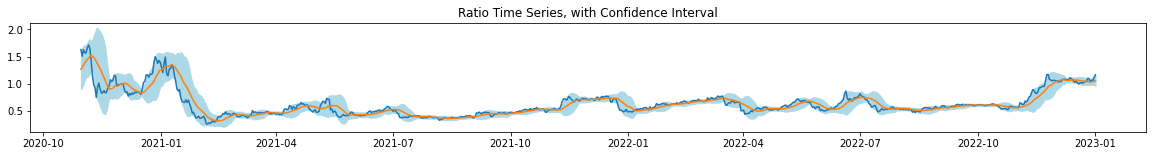

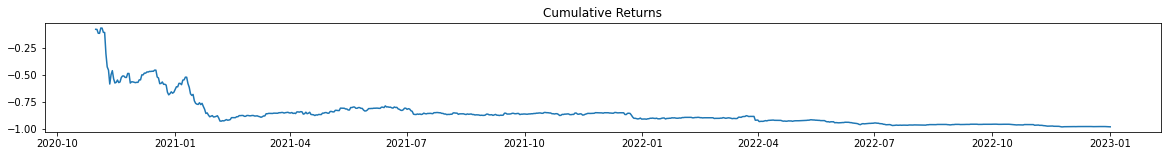

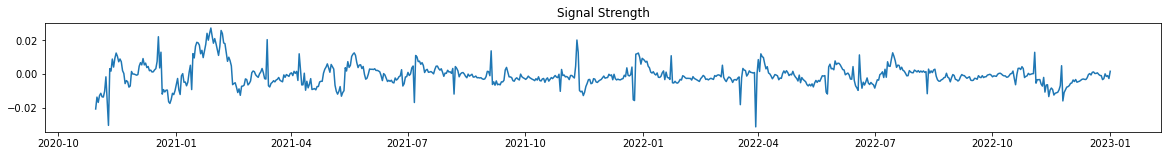

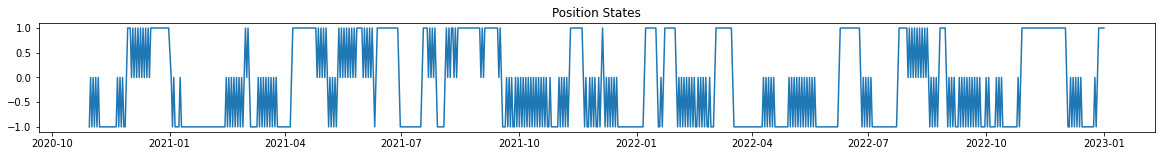

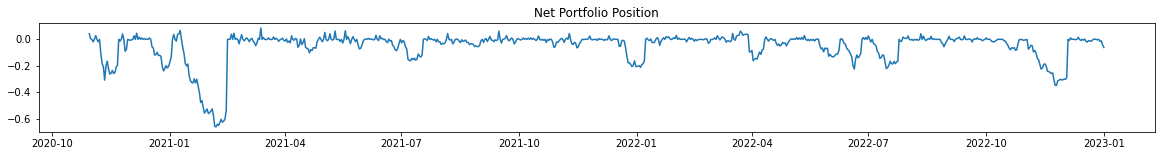

In [25]:
mod.plot_all()